# Cell Cell Communication inference

## Introduction
Cells are not independent entities in biology, they react to stimuli coming from their environment. Cells can react to chemical cues, but also to other cells. These cell-cell signaling events can trigger crucial biological processes like apoptosis or cell migration, making the study of them relevant to better understand diseases. Cell-cell communication (CCC) events can be inferred from trascriptomics using a prior knowledge resource and a statistical method.

The goals of this tutorial are to:

- Introduce the CCC concept
- Learn how to run CCC methods
- Interpret the obtained scores

To do so, we will analyse a single-cell transcriptomics dataset consisting of bone marrow cells. We leverage the tool [LIANA](https://liana-py.readthedocs.io/), a collection of CCC inference methods that can query prior knowledge to generate hypothesis of cell interactions.

## Dependencies
To be able to run the code, we first need to load the required packages.

In [1]:
# Single-cell processing
import scanpy as sc

# CCC analysis
import liana as li

# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Hide ugly warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3))

## Data loading

To load the processed dataset run. With this we obtain an `AnnData` object:

In [2]:
# Read adata object
adata = sc.read_h5ad('data/Donor_1_Monocle3_base_pipeline.h5ad')
adata

AnnData object with n_obs × n_vars = 2290 × 25228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'mapping.score', 'Cell.type', 'Size_Factor', 'monocle3_pseudotime', 'monocle3_lieden_clusters', 'monocle3_partition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_short_name'

Inside an `AnnData` object we have different attributes, here are the most important ones:

* X: This is where the main assay is stored, in this case log-transformed normalized counts
* obs: Metadata dataframe for cells (rows)
* var: Metadata dataframe for genes (columns)

You can read more about it in the official [documentation](https://anndata.readthedocs.io/en/latest/index.html)

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg"
     width="400" 
     height="500" />
     
Next we will load the previously obtained UMAP results, we will store the raw counts in the `.layers` attribute and log-normalize the gene expression counts:

In [3]:
# Read umap values
adata.obsm['X_umap'] = pd.read_csv('data/Donor_1_Monocle3_base_pipeline_umap.csv', index_col=0).values

# Store raw counts in layers
adata.layers['counts'] = adata.X.copy()

# log-normalize conunts in X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata

AnnData object with n_obs × n_vars = 2290 × 25228
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'mapping.score', 'Cell.type', 'Size_Factor', 'monocle3_pseudotime', 'monocle3_lieden_clusters', 'monocle3_partition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_short_name'
    uns: 'log1p'
    obsm: 'X_umap'
    layers: 'counts'

We can visualize which cell types are present:

... storing 'Phase' as categorical
... storing 'predicted.celltype.l2' as categorical
... storing 'predicted.celltype.l1' as categorical
... storing 'Cell.type' as categorical
... storing 'cell_type' as categorical


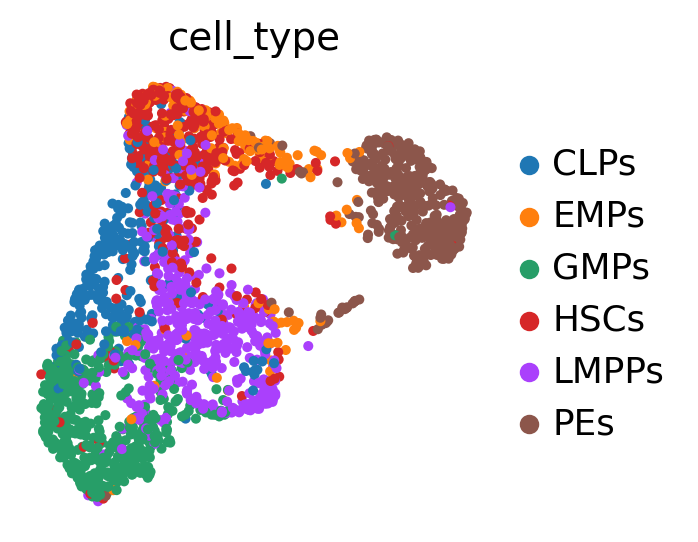

In [4]:
# Simplify cell type names
adata.obs['cell_type'] = adata.obs['Cell.type'].str.extract(r'\((.*?)\)')

# Plot
sc.pl.umap(adata, color=['cell_type'])

## Inference of CCC events at the cluster level
Recently, multiple tools and resources that infer CCC were published with different modeling strategies. All of them assume that CCC events can be inferred only from transcriptomics. They check the expression of ligands coming from a "source" cell type and a receptor from a "target" cell type that are known to interact. If both protein genes are expressed, the methods return these interactions as being relevant for the given dataset.

<div class="alert alert-block alert-info"> Discuss what are the limitations of assuming that CCC events can be inferred from only transcriptomics. Think about how interactions between cells can occur. </div>


Moreover, multiple prior knowledge resources of CCC interaction are available coming from different studies. You can print them with this line:

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Despite this, most published methods use a fixed resource and ignore the rest.

<div class="alert alert-block alert-info"> Discuss what happens if only one resource and method are taken into consideration while ignoring the others. </div>

To start, we will infer CCC interactions using the `natmi` method with the resource provided in their manuscript, connectomeDB2020. `natmi` ranks CCC events by computing the product between genes.

We will leverage the easy to use wrapper provided by liana:

In [6]:
li.mt.natmi(
    adata,
    groupby='cell_type',
    resource_name='connectomedb2020',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True
)

res_natmi_connectomedb2020 = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.natmi.magnitude, ascending=li.mt.natmi.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.natmi.magnitude, li.mt.natmi.specificity]]
)

res_natmi_connectomedb2020

Using `.X`!
38 features of mat are empty, they will be removed.
Using resource `connectomedb2020`.
0.32 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2290 samples and 25190 features


,ligand_complex,receptor_complex,source,target,expr_prod,spec_weight
0,VIM,CD44,GMPs,CLPs,2.041677,0.051411
1,VIM,CD44,LMPPs,CLPs,1.736257,0.043720
2,VIM,CD44,CLPs,CLPs,1.708853,0.043030
3,VIM,CD44,HSCs,CLPs,1.646822,0.041468
4,VIM,CD44,GMPs,HSCs,1.644356,0.041406
...,...,...,...,...,...,...
1867,GPI,AMFR,CLPs,CLPs,0.005704,0.022816
1868,GPI,AMFR,PEs,EMPs,0.005415,0.021658
1869,GPI,AMFR,PEs,LMPPs,0.005168,0.020670
1870,GPI,AMFR,PEs,CLPs,0.004988,0.019950


We can visualize the results:

In [7]:
def plot_inter(ligand, receptor, source, target):
    fig, axes = plt.subplots(2, 2, figsize=(5.5, 5), tight_layout=True)
    axes = axes.ravel()
    ax = axes[0]
    sc.pl.umap(adata, color=ligand, show=False, ax=ax)
    ax = axes[1]
    sc.pl.umap(adata, color=receptor, show=False, ax=ax)
    ax = axes[2]
    msk = (adata.obs['cell_type'] == source)
    sc.pl.violin(adata[msk].copy(), keys=ligand, show=False, ax=ax, groupby='cell_type')
    ax = axes[3]
    msk = (adata.obs['cell_type'] == target)
    sc.pl.violin(adata[msk].copy(), keys=receptor, show=False, ax=ax, groupby='cell_type')
    plt.show()

def plot_top_inters(df, top=100, n=10):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), tight_layout=True)
    ax = axes[0]
    (
        df
        .head(top)
        .assign(interaction=lambda x: x['ligand_complex'] + '^' + x['receptor_complex'])
        .groupby('interaction')
        .count()
        [['target']]
        .sort_values('target', ascending=True)
        .head(n)
        .plot.barh(ax=ax)
    )
    ax.legend().set_visible(False)
    ax.set_title('ligand^receptor')
    ax.set_ylabel('')


    ax = axes[1]
    (
        df
        .head(top)
        .assign(pair=lambda x: x['source'] + '^' + x['target'])
        .groupby('pair')
        .count()
        [['ligand_complex']]
        .sort_values('ligand_complex', ascending=True)
        .head(n)
        .plot.barh(ax=ax)
    )
    ax.legend().set_visible(False)
    ax.set_title('source^target')
    ax.set_ylabel('')
    plt.show()

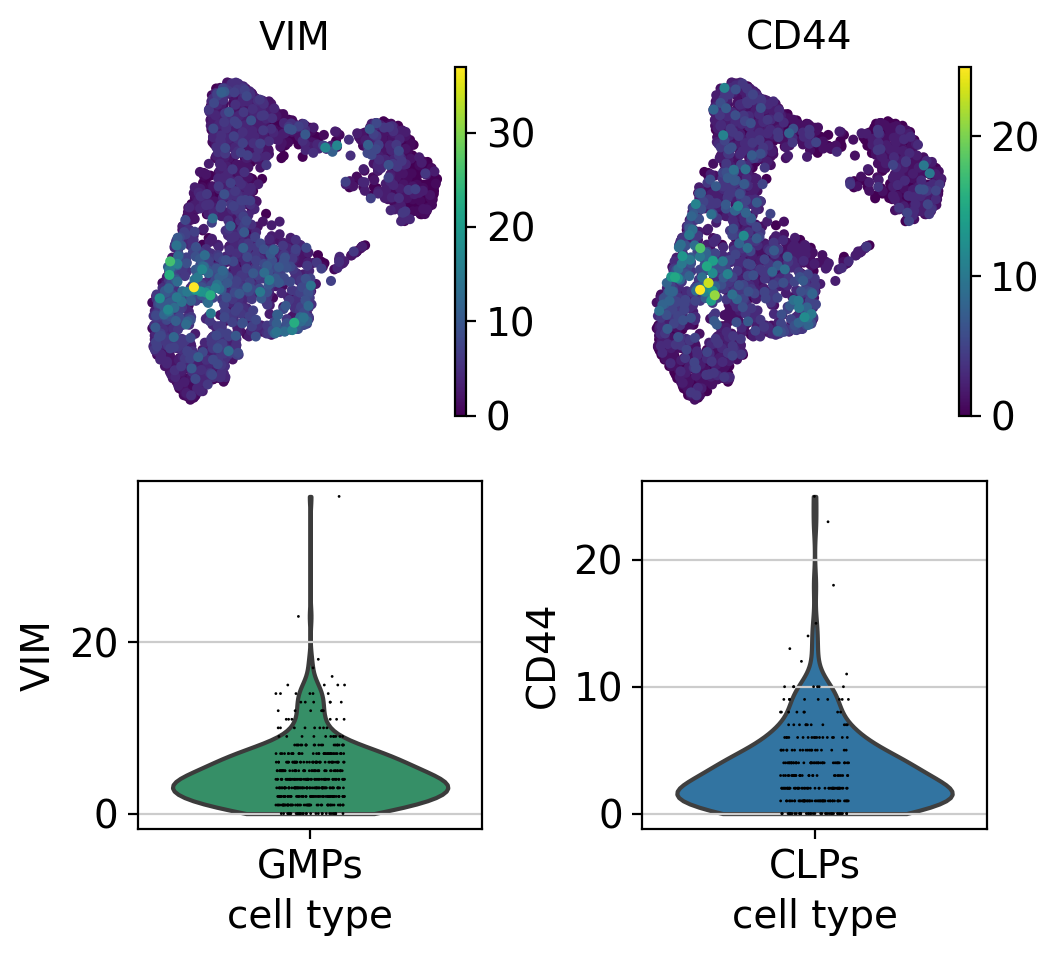

In [8]:
# Top
plot_inter(
    ligand='VIM',
    receptor='CD44',
    source='GMPs',
    target='CLPs'
)

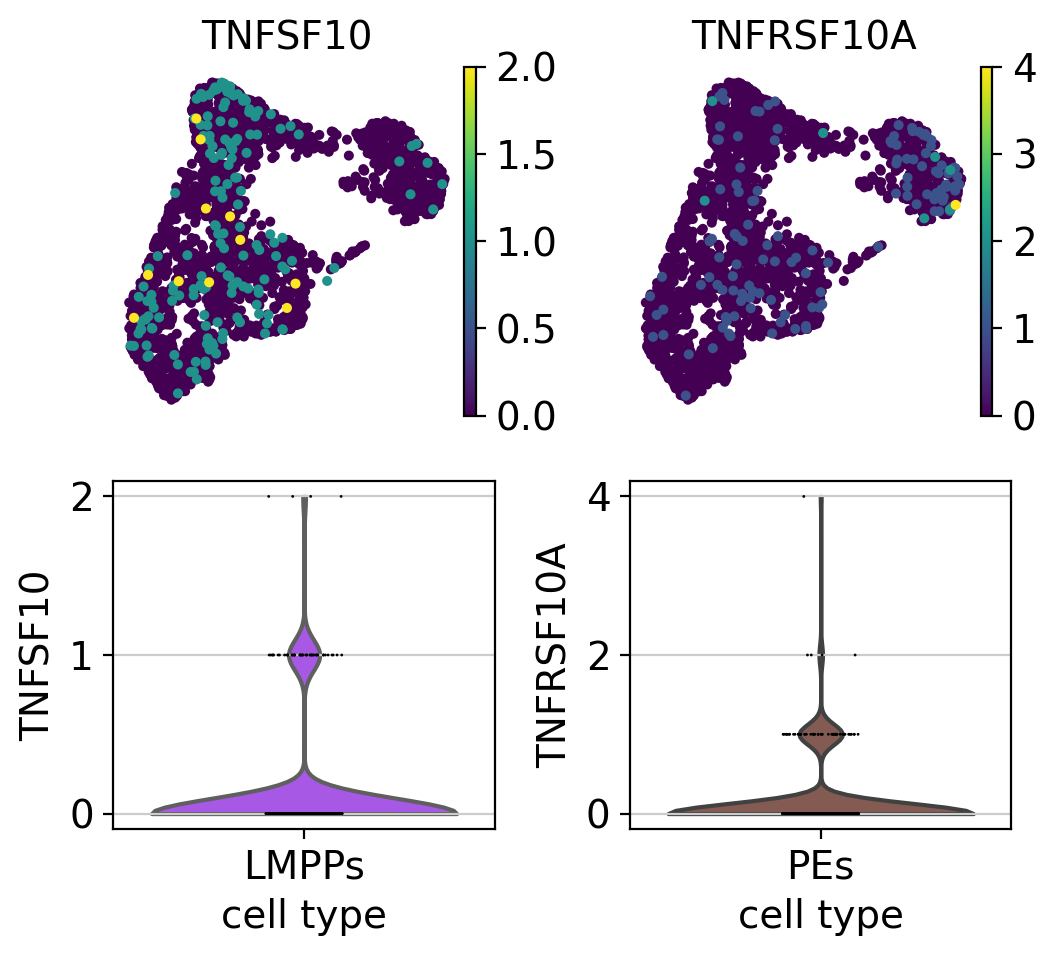

In [9]:
# Bottom
plot_inter(
    ligand='TNFSF10',
    receptor='TNFRSF10A',
    source='LMPPs',
    target='PEs'
)

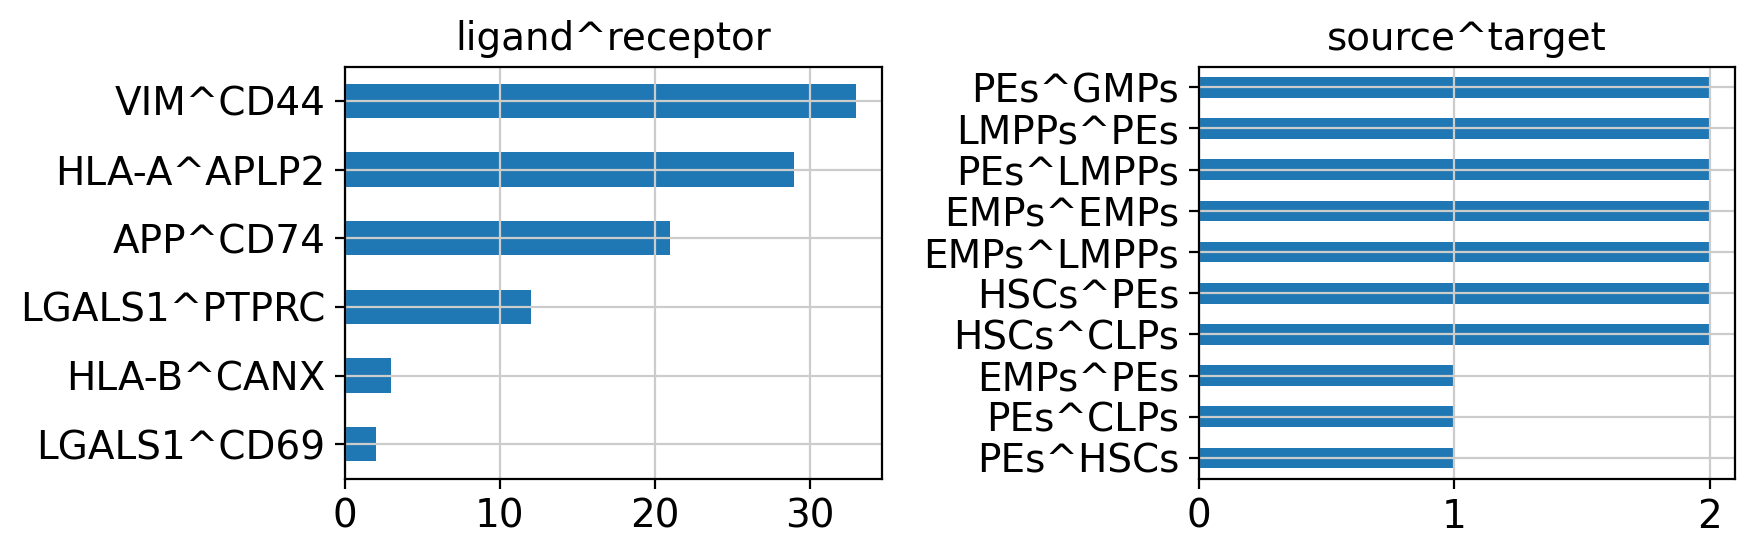

In [10]:
plot_top_inters(res_natmi_connectomedb2020, top=100)

<div class="alert alert-block alert-info"> Explore a little bit the obtained results, do they make biological sense? Search for literature. </div>

Now we will run it again, but this time changing the resource to CellPhoneDB, another popular ligad-receptor database.

In [11]:
li.mt.natmi(
    adata,
    groupby='cell_type',
    resource_name='cellphonedb',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True
)

res_natmi_cellphonedb = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.natmi.magnitude, ascending=li.mt.natmi.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.natmi.magnitude, li.mt.natmi.specificity]]
)

res_natmi_cellphonedb

Using `.X`!
38 features of mat are empty, they will be removed.
Using resource `cellphonedb`.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2290 samples and 25190 features


,ligand_complex,receptor_complex,source,target,expr_prod,spec_weight
0,APP,CD74,CLPs,CLPs,1.119151,0.054369
1,APP,CD74,CLPs,HSCs,0.973257,0.047281
2,APP,CD74,HSCs,CLPs,0.907897,0.044106
3,APP,CD74,CLPs,LMPPs,0.907763,0.044099
4,APP,CD74,LMPPs,CLPs,0.879565,0.042730
...,...,...,...,...,...,...
461,TNFSF10,TNFRSF10B,LMPPs,CLPs,0.005709,0.058236
462,TNFSF10,RIPK1,LMPPs,HSCs,0.005655,0.027631
463,FAM3C,ADGRG5,PEs,LMPPs,0.004527,0.032417
464,TNFSF10,TNFRSF10A,LMPPs,PEs,0.004454,0.064178


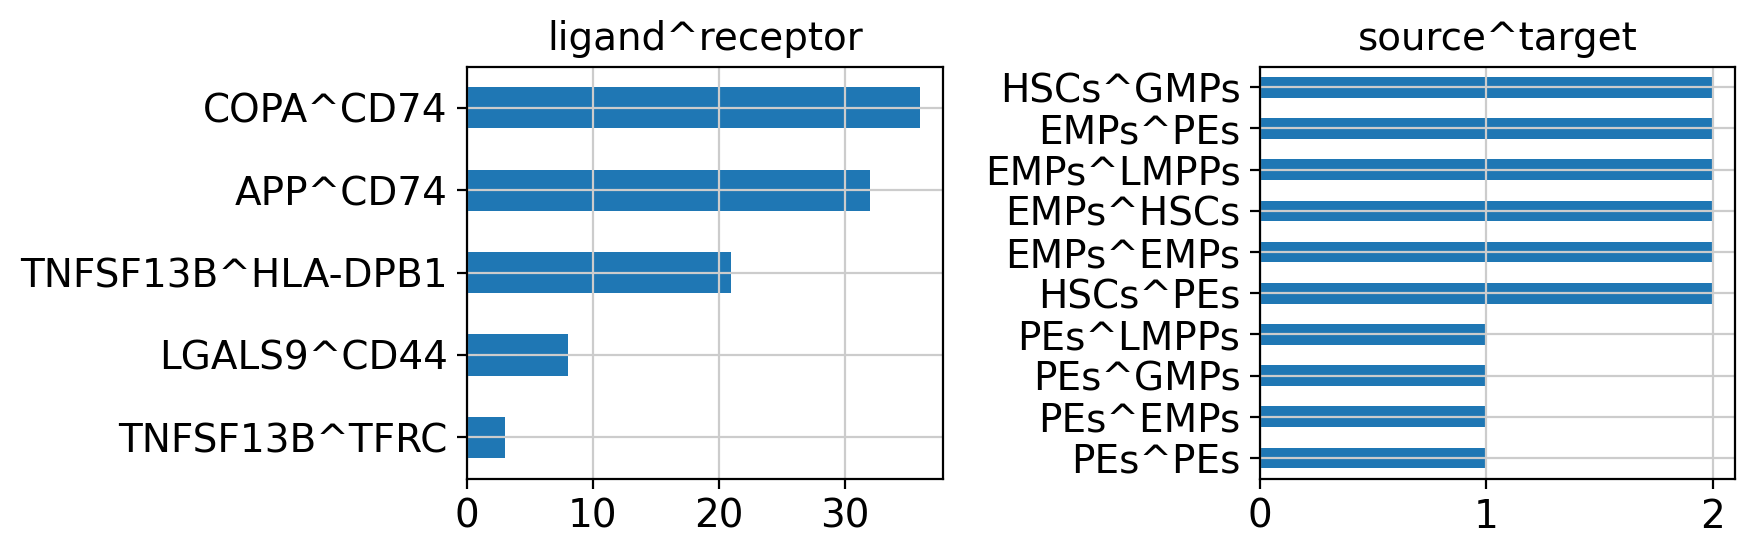

In [12]:
plot_top_inters(res_natmi_cellphonedb, top=100)

<div class="alert alert-block alert-info"> Compare the results, are they the same? What is the number of shared interactions between the top 100 of both runs? </div>


In [13]:
# Explore
res_top_natmi = pd.merge(
    res_natmi_connectomedb2020.head(100).reset_index(names='rank'),
    res_natmi_cellphonedb.head(100).reset_index(names='rank'),
    on=['ligand_complex', 'receptor_complex', 'source', 'target'],
    how='inner',
    suffixes=['_natmi_connectomedb2020', '_natmi_cellphonedb']
)[['ligand_complex', 'receptor_complex', 'source', 'target', 'rank_natmi_connectomedb2020', 'expr_prod_natmi_connectomedb2020', 'rank_natmi_cellphonedb', 'expr_prod_natmi_cellphonedb']]
res_top_natmi

,ligand_complex,receptor_complex,source,target,rank_natmi_connectomedb2020,expr_prod_natmi_connectomedb2020,rank_natmi_cellphonedb,expr_prod_natmi_cellphonedb
0,APP,CD74,CLPs,CLPs,23,1.119151,0,1.119151
1,APP,CD74,CLPs,HSCs,38,0.973257,1,0.973257
2,APP,CD74,HSCs,CLPs,43,0.907897,2,0.907897
3,APP,CD74,CLPs,LMPPs,44,0.907763,3,0.907763
4,APP,CD74,LMPPs,CLPs,48,0.879565,4,0.879565
5,APP,CD74,CLPs,EMPs,54,0.828953,5,0.828953
6,APP,CD74,HSCs,HSCs,58,0.789543,6,0.789543
7,APP,CD74,GMPs,CLPs,59,0.781924,7,0.781924
8,APP,CD74,LMPPs,HSCs,61,0.764904,8,0.764904
9,APP,CD74,CLPs,GMPs,63,0.737598,9,0.737598


Now let's try what happens when we change the method, in this case `cellphonedb` which computes the mean of the means between two cell types. 

In [14]:
li.mt.cellphonedb(
    adata,
    groupby='cell_type',
    resource_name='cellphonedb',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True,
    n_perms=1
)

res_cellphonedb_cellphonedb = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.cellphonedb.magnitude, ascending=li.mt.cellphonedb.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.cellphonedb.magnitude, li.mt.cellphonedb.specificity]]
)

res_cellphonedb_cellphonedb

Using `.X`!
38 features of mat are empty, they will be removed.
Using resource `cellphonedb`.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2290 samples and 25190 features


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 327.25it/s]


,ligand_complex,receptor_complex,source,target,lr_means,cellphone_pvals
0,APP,CD74,CLPs,CLPs,1.460443,0.0
1,APP,CD74,HSCs,CLPs,1.417632,0.0
2,APP,CD74,LMPPs,CLPs,1.411891,0.0
3,APP,CD74,GMPs,CLPs,1.392103,0.0
4,COPA,CD74,CLPs,CLPs,1.378716,0.0
...,...,...,...,...,...,...
461,TNFSF10,TNFRSF10B,LMPPs,CLPs,0.076922,0.0
462,TNFSF10,RIPK1,LMPPs,HSCs,0.076486,0.0
463,FAM3C,ADGRG5,PEs,LMPPs,0.067386,0.0
464,TNFSF10,TNFRSF10A,LMPPs,PEs,0.066884,0.0


Like before, compare the top 100 interactions but now across the three different results

In [15]:
# Explore
pd.merge(
    res_top_natmi,
    res_cellphonedb_cellphonedb.head(100).reset_index(names='rank'),
    on=['ligand_complex', 'receptor_complex', 'source', 'target'],
    how='inner',
)

,ligand_complex,receptor_complex,source,target,rank_natmi_connectomedb2020,expr_prod_natmi_connectomedb2020,rank_natmi_cellphonedb,expr_prod_natmi_cellphonedb,rank,lr_means,cellphone_pvals
0,APP,CD74,CLPs,CLPs,23,1.119151,0,1.119151,0,1.460443,0.0
1,APP,CD74,CLPs,HSCs,38,0.973257,1,0.973257,11,1.299623,0.0
2,APP,CD74,HSCs,CLPs,43,0.907897,2,0.907897,1,1.417632,0.0
3,APP,CD74,CLPs,LMPPs,44,0.907763,3,0.907763,16,1.227429,0.0
4,APP,CD74,LMPPs,CLPs,48,0.879565,4,0.879565,2,1.411891,0.0
5,APP,CD74,CLPs,EMPs,54,0.828953,5,0.828953,28,1.140557,0.0
6,APP,CD74,HSCs,HSCs,58,0.789543,6,0.789543,13,1.256812,0.0
7,APP,CD74,GMPs,CLPs,59,0.781924,7,0.781924,3,1.392103,0.0
8,APP,CD74,LMPPs,HSCs,61,0.764904,8,0.764904,14,1.251071,0.0
9,APP,CD74,CLPs,GMPs,63,0.737598,9,0.737598,46,1.039855,1.0


What do you think of the overlap, are they comparable?

As you have seen, results tend to be quite different depending on the choice of method and prior knowledge database. To try to mitigate this, `liana` uses a consensus database as the prior knowledge resource (where interactions coming from different resources where aggregated). It also runs several top-performing CCC inference methods sequentially to find a consensus ranking of interactions. We can run it with:

In [16]:
# Run rank_aggregate
li.mt.rank_aggregate(
    adata,
    groupby='cell_type',
    resource_name='consensus',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True
)

Using `.X`!
38 features of mat are empty, they will be removed.
Using resource `consensus`.
0.30 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2290 samples and 25190 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.21it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.41it/s]


In [17]:
adata.uns['liana_res']

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
3082,CLPs,PEs,B2M,TFRC,1.760590,0.000,1.626152,0.658326,0.522754,0.068732,0.935475,0.075484,0.0,0.000587,0.000001
3484,LMPPs,PEs,B2M,TFRC,1.735383,0.000,1.598590,0.604318,0.469024,0.067567,0.934957,0.073466,0.0,0.000587,0.000002
3378,HSCs,PEs,B2M,TFRC,1.626549,0.000,1.479591,0.371125,0.301792,0.062537,0.932565,0.069448,0.0,0.000587,0.000003
207,GMPs,CLPs,VIM,CD44,1.439867,0.000,2.041677,0.538785,0.624238,0.051411,0.942012,0.106117,0.0,0.000587,0.000004
3287,GMPs,PEs,B2M,TFRC,1.586202,0.000,1.435476,0.284672,0.238137,0.060673,0.931607,0.067416,0.0,0.000587,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,LMPPs,LMPPs,ACTR2,LDLR,0.288478,0.365,0.057526,0.022662,-0.026464,0.032839,0.731675,0.000000,1.0,1.000000,1.000000
2856,LMPPs,LMPPs,HSPA8,LDLR,0.518400,0.000,0.116471,0.116889,0.074612,0.039074,0.795083,0.000000,1.0,0.179352,1.000000
2858,LMPPs,LMPPs,IL1B,SIGIRR,0.202733,0.286,0.033666,0.013152,-0.020452,0.027460,0.675958,0.000000,1.0,1.000000,1.000000
2862,LMPPs,LMPPs,NAMPT,INSR,0.147305,0.893,0.021569,-0.028390,-0.058752,0.026199,0.625425,0.000000,1.0,1.000000,1.000000


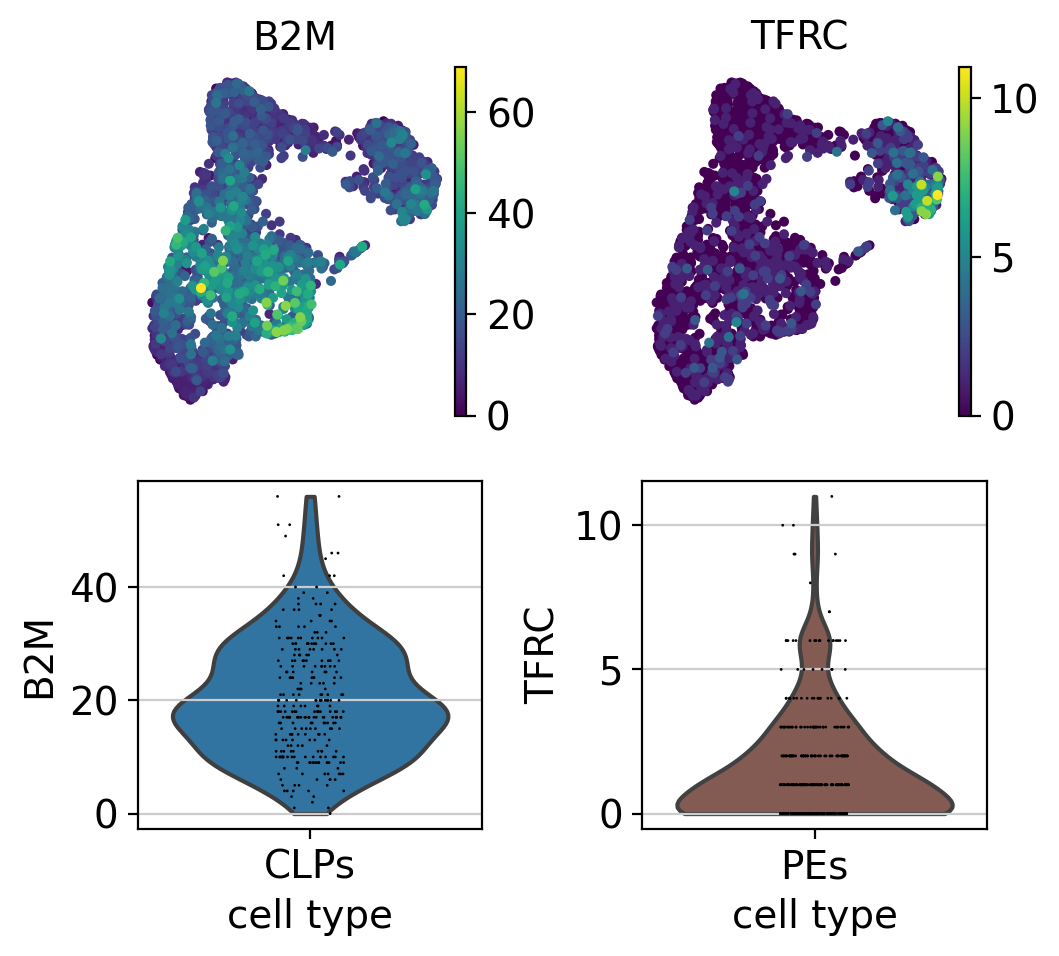

In [18]:
# Bottom
plot_inter(
    ligand='B2M',
    receptor='TFRC',
    source='CLPs',
    target='PEs'
)

We can simultaneously visualize the top interactions by running

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


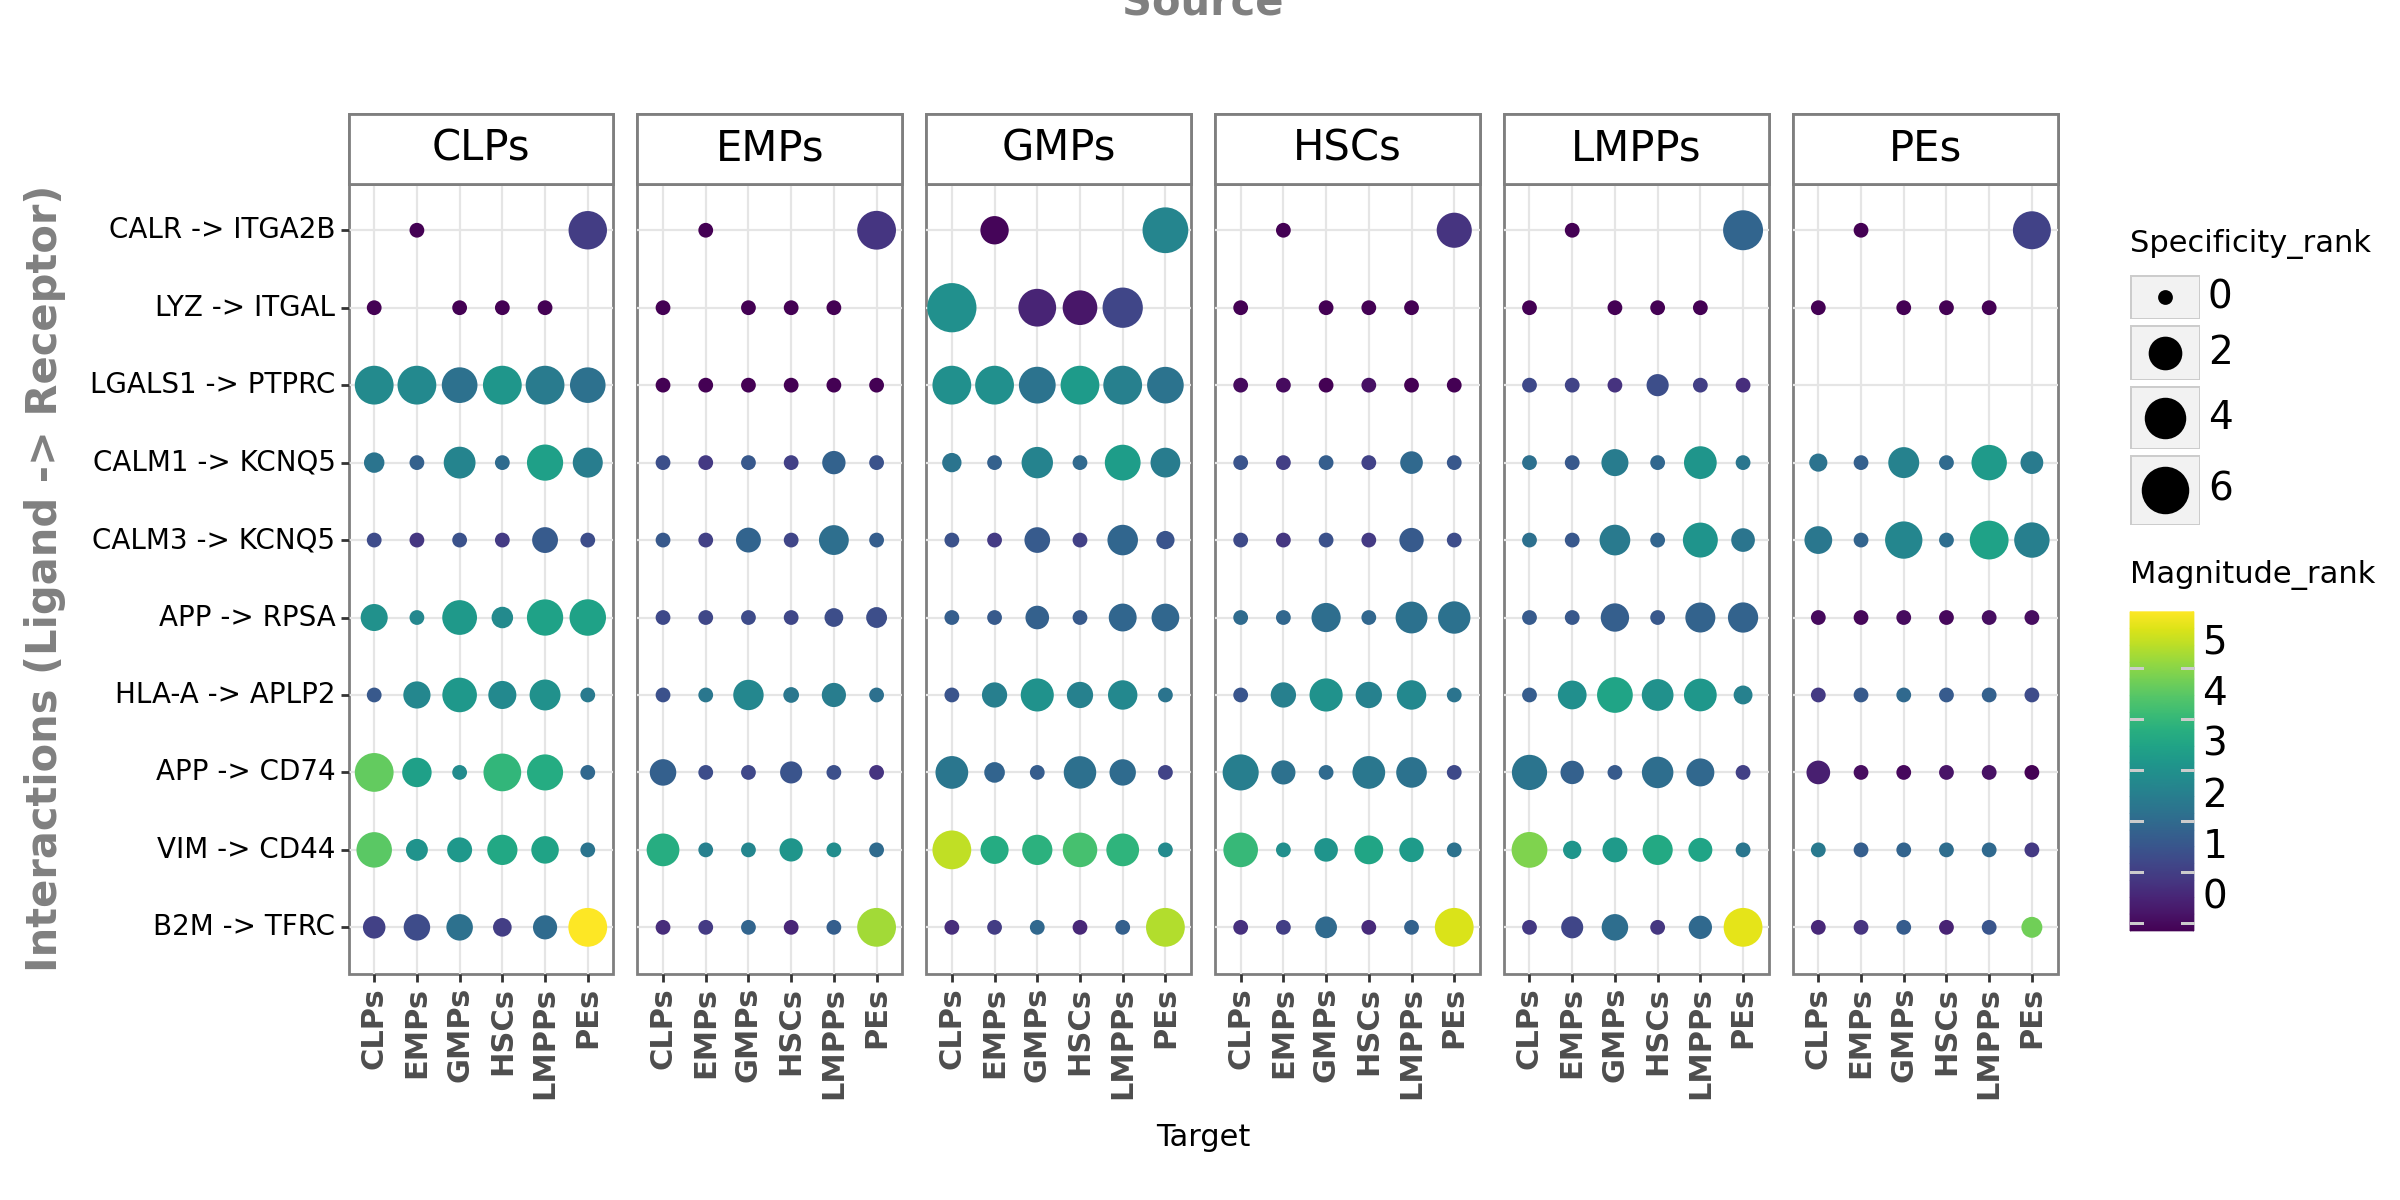

<Figure Size: (1200 x 600)>

In [19]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True, # we inverse sign since we want small p-values to have large sizes
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(12, 6)
             )